In [2]:
import os
import cv2
import numpy as np

# Set paths - update accordingly
DATASET_DIR = r"C:\Users\91888\Desktop\MI\LIDC-IDRI-slices"    # Your dataset root
OVERLAY_DIR = r"C:\Users\91888\Desktop\MI\LIDC-IDRI-overlay"  # Output overlays folder

alpha = 0.4  # Transparency of the mask overlay (0.0 no effect, 1.0 fully masked)
mask_gray_value = 128  # Intensity of gray overlay for mask area (can adjust for lighter/darker)

os.makedirs(OVERLAY_DIR, exist_ok=True)

for patient in sorted(os.listdir(DATASET_DIR)):
    patient_path = os.path.join(DATASET_DIR, patient)
    if not os.path.isdir(patient_path):
        continue

    for nodule in sorted(os.listdir(patient_path)):
        nodule_path = os.path.join(patient_path, nodule)
        if not os.path.isdir(nodule_path):
            continue

        images_path = os.path.join(nodule_path, 'images')
        if not os.path.isdir(images_path):
            continue

        image_files = sorted(os.listdir(images_path))
        mask_folders = sorted([f for f in os.listdir(nodule_path) if f.startswith('mask')])

        for img_file in image_files:
            img_path = os.path.join(images_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: could not read image {img_path}")
                continue

            for mask_folder in mask_folders:
                mask_path = os.path.join(nodule_path, mask_folder, img_file)
                if os.path.exists(mask_path):
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    if mask is None:
                        print(f"Warning: could not read mask {mask_path}")
                        continue
                    overlayed = img.copy()
                    mask_area = mask > 0
                    # Blending mask_gray_value with original image on masked region
                    overlayed[mask_area] = (alpha * mask_gray_value + (1 - alpha) * img[mask_area]).astype(np.uint8)
                else:
                    overlayed = img.copy()

                overlay_dir = os.path.join(OVERLAY_DIR, patient, nodule, mask_folder)
                os.makedirs(overlay_dir, exist_ok=True)
                save_path = os.path.join(overlay_dir, img_file)
                cv2.imwrite(save_path, overlayed)

print("Completed blending mask overlays for all images and masks.")


Completed blending mask overlays for all images and masks.


In [3]:
import os
import cv2
import numpy as np

OVERLAY_DIR = r"C:\Users\91888\Desktop\MI\LIDC-IDRI-overlay"
PREPROCESS_DIR = r"C:\Users\91888\Desktop\MI\LIDC-IDRI-pp\final_image"
os.makedirs(PREPROCESS_DIR, exist_ok=True)

# Automatically get all patient folders
folders_to_process = sorted([
    f for f in os.listdir(OVERLAY_DIR)
    if os.path.isdir(os.path.join(OVERLAY_DIR, f))
])

def apply_window(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    windowed_img = np.clip(image, img_min, img_max)
    windowed_img = ((windowed_img - img_min) / window_width) * 255.0
    return windowed_img.astype(np.uint8)

def contrast_enhancement(img):
    clahe = cv2.createCLAHE(clipLimit=3.5, tileGridSize=(4,4))  # Subtler contrast
    return clahe.apply(img)

def sharpening(img):
    gaussian = cv2.GaussianBlur(img, (3,3), 1.0)  # Small kernel
    return cv2.addWeighted(img, 2.0, gaussian, -1.0, 0)  # Stronger sharpening

WINDOW_CENTER = 40
WINDOW_WIDTH = 150

for patient in folders_to_process:
    patient_path = os.path.join(OVERLAY_DIR, patient)
    if not os.path.isdir(patient_path):
        print(f"Skipping missing folder: {patient}")
        continue
   
    for nodule in sorted(os.listdir(patient_path)):
        nodule_path = os.path.join(patient_path, nodule)
        if not os.path.isdir(nodule_path):
            continue
       
        for mask_folder in sorted(os.listdir(nodule_path)):
            mask_path = os.path.join(nodule_path, mask_folder)
            if not os.path.isdir(mask_path):
                continue
           
            image_files = sorted(os.listdir(mask_path))
            for img_file in image_files:
                img_path = os.path.join(mask_path, img_file)
                img_original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_original is None:
                    print(f"Warning: could not read image {img_path}")
                    continue
               
                # ---- Stepwise Preprocessing ----
                img_step1 = apply_window(img_original, WINDOW_CENTER, WINDOW_WIDTH)
                img_step2 = sharpening(img_step1)  # Sharpening second
                img_final = contrast_enhancement(img_step2)  # Contrast last
                # ---- Save to 'each_step' subfolder ----
                step_dir = os.path.join(PREPROCESS_DIR, "each_step", patient, nodule, mask_folder)
                os.makedirs(step_dir, exist_ok=True)
                base_name = os.path.splitext(img_file)[0]
                cv2.imwrite(os.path.join(step_dir, f"{base_name}_window.png"), img_step1)
                cv2.imwrite(os.path.join(step_dir, f"{base_name}_sharpened.png"), img_step2)
                cv2.imwrite(os.path.join(step_dir, f"{base_name}_contrast.png"), img_final)
                # ---- Save only final preprocessed image ----
                final_dir = os.path.join(PREPROCESS_DIR, "final_image", patient, nodule, mask_folder)
                os.makedirs(final_dir, exist_ok=True)
                cv2.imwrite(os.path.join(final_dir, f"{base_name}_preprocessed.png"), img_final)
print("Preprocessing complete: stepwise images and final images saved separately.")

Preprocessing complete: stepwise images and final images saved separately.


In [12]:
import os
import cv2
import numpy as np

# ==== PATHS ====
input_dir = r"C:\Users\91888\Desktop\MI\LIDC-IDRI-pp\final_image"
output_classical_mask = r"C:\Users\91888\Desktop\MI\LIDC-IDRI-segmented\Mask"
output_classical_img  = r"C:\Users\91888\Desktop\MI\LIDC-IDRI-segmented\Masked Images"

# ==== CREATE BASE OUTPUT FOLDERS ====
os.makedirs(output_classical_mask, exist_ok=True)
os.makedirs(output_classical_img, exist_ok=True)

# ==== LOOP THROUGH ALL IMAGES ====
for root, _, files in os.walk(input_dir):
    for file in files:
        if not file.lower().endswith(".png"):
            continue
        
        img_path = os.path.join(root, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        
        # ==== CLASSICAL SEGMENTATION (Otsu + Morphology) ====
        # Step 1: Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(img, (5, 5), 0)
        # Step 2: Otsu thresholding
        _, mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        # Step 3: Morphological cleanup
        kernel = np.ones((3, 3), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

        # ==== APPLY MASK ====
        masked_img = cv2.bitwise_and(img, img, mask=mask)

        # ==== CREATE MIRRORED FOLDER STRUCTURE ====
        rel_path = os.path.relpath(root, input_dir)  # e.g., "LIDC-IDRI-0001\nodule-0\images"
        mask_subdir = os.path.join(output_classical_mask, rel_path)
        img_subdir  = os.path.join(output_classical_img, rel_path)
        os.makedirs(mask_subdir, exist_ok=True)
        os.makedirs(img_subdir, exist_ok=True)

        # ==== SAVE FILES ====
        mask_out_path = os.path.join(mask_subdir, file)
        img_out_path  = os.path.join(img_subdir, file)
        cv2.imwrite(mask_out_path, mask)
        cv2.imwrite(img_out_path, masked_img)

print("✅ Classical segmentation completed successfully!.")


✅ Classical segmentation completed successfully!.


In [13]:
import os
import shutil

# === Root directory (adjust as needed) ===
root_dir = r"C:\Users\91888\Desktop\MI\LIDC-IDRI-segmented\Masked Images"

# === Walk through all subdirectories ===
for current_path, dirs, files in os.walk(root_dir, topdown=False):
    for d in dirs:
        if d.lower().startswith("mask"):  # Case-insensitive match
            folder_path = os.path.join(current_path, d)
            try:
                shutil.rmtree(folder_path)  # Delete folder and its contents
                print(f"🗑️ Deleted: {folder_path}")
            except Exception as e:
                print(f"⚠️ Error deleting {folder_path}: {e}")

print("✅ Cleanup complete! All 'mask*' folders removed.")


🗑️ Deleted: C:\Users\Admin\Desktop\MI Project\Segmentation Output\Classical\Masked Images\LIDC-IDRI-0001\nodule-0\mask-0
🗑️ Deleted: C:\Users\Admin\Desktop\MI Project\Segmentation Output\Classical\Masked Images\LIDC-IDRI-0001\nodule-0\mask-1
🗑️ Deleted: C:\Users\Admin\Desktop\MI Project\Segmentation Output\Classical\Masked Images\LIDC-IDRI-0001\nodule-0\mask-2
🗑️ Deleted: C:\Users\Admin\Desktop\MI Project\Segmentation Output\Classical\Masked Images\LIDC-IDRI-0001\nodule-0\mask-3
🗑️ Deleted: C:\Users\Admin\Desktop\MI Project\Segmentation Output\Classical\Masked Images\LIDC-IDRI-0002\nodule-0\mask-0
🗑️ Deleted: C:\Users\Admin\Desktop\MI Project\Segmentation Output\Classical\Masked Images\LIDC-IDRI-0002\nodule-0\mask-1
🗑️ Deleted: C:\Users\Admin\Desktop\MI Project\Segmentation Output\Classical\Masked Images\LIDC-IDRI-0002\nodule-0\mask-2
🗑️ Deleted: C:\Users\Admin\Desktop\MI Project\Segmentation Output\Classical\Masked Images\LIDC-IDRI-0002\nodule-0\mask-3
🗑️ Deleted: C:\Users\Admin\Deskt

In [14]:
!pip install openpyxl


[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import os
import shutil

# ==== PATHS ====
base_dir = r"C:\Users\91888\Desktop\MI\LIDC-IDRI-segmented\Mask"

# Recursively delete folders starting with 'image'
def delete_image_folders(directory):
    for root, dirs, files in os.walk(directory, topdown=False):
        for dir_name in dirs:
            if dir_name.lower().startswith("image"):
                folder_path = os.path.join(root, dir_name)
                try:
                    shutil.rmtree(folder_path)
                    print(f"Deleted: {folder_path}")
                except Exception as e:
                    print(f"Error deleting {folder_path}: {e}")

# Process the directory
delete_image_folders(base_dir)

print("✅ Folder cleanup completed successfully!")

✅ Folder cleanup completed successfully!


In [4]:
import os
import cv2
import numpy as np

# ==== PATHS ====
input_mask_dir = r"C:\Users\91888\Desktop\MI\LIDC-IDRI-segmented\Mask"
output_combined_dir = r"C:\Users\91888\Desktop\MI\LIDC-IDRI-segmented\Combined Masks"

# ==== CREATE OUTPUT FOLDER ====
os.makedirs(output_combined_dir, exist_ok=True)

# Get first 10 LIDC-IDRI folders
lidc_folders = [f for f in os.listdir(input_mask_dir) if f.startswith("LIDC-IDRI-")][:10]
for folder in lidc_folders:
    folder_path = os.path.join(input_mask_dir, folder)
    if not os.path.isdir(folder_path):
        continue
    
    # Dictionary to store masks by slice
    slice_masks = {}
    
    for root, _, files in os.walk(folder_path):
        for file in files:
            if not file.lower().endswith(".png"):
                continue
            
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            
            # Extract slice number from filename (assuming format like "slice-0.png")
            slice_num = file.split('-')[1].split('.')[0]
            rel_path = os.path.relpath(root, folder_path)
            nodule_name = os.path.basename(os.path.dirname(rel_path)) if rel_path else "Nodule-0"
            
            key = f"{nodule_name},Slice {slice_num}"
            if key not in slice_masks:
                slice_masks[key] = []
            slice_masks[key].append(img)
    
    # Combine masks for each slice
    for key, masks in slice_masks.items():
        if masks:
            # Combine all masks using logical OR
            combined_mask = np.zeros_like(masks[0], dtype=np.uint8)
            for mask in masks:
                combined_mask = cv2.bitwise_or(combined_mask, mask)
            
            # Determine output subdirectory (mirror nodule structure)
            nodule_part = key.split(',')[0].replace("Nodule ", "Nodule-")
            output_subdir = os.path.join(output_combined_dir, folder, nodule_part)
            os.makedirs(output_subdir, exist_ok=True)
            
            # Save combined mask
            slice_part = key.split(',')[1].replace("Slice ", "slice-") + ".png"
            output_path = os.path.join(output_subdir, slice_part)
            cv2.imwrite(output_path, combined_mask)
            print(f"Combined mask saved: {output_path}")

print("✅ Mask combination completed successfully!")

Combined mask saved: C:\Users\Admin\Desktop\MI Project\Segmentation Output\Combined Masks\LIDC-IDRI-0001\nodule-0\slice-0.png
Combined mask saved: C:\Users\Admin\Desktop\MI Project\Segmentation Output\Combined Masks\LIDC-IDRI-0001\nodule-0\slice-1.png
Combined mask saved: C:\Users\Admin\Desktop\MI Project\Segmentation Output\Combined Masks\LIDC-IDRI-0001\nodule-0\slice-2.png
Combined mask saved: C:\Users\Admin\Desktop\MI Project\Segmentation Output\Combined Masks\LIDC-IDRI-0001\nodule-0\slice-3.png
Combined mask saved: C:\Users\Admin\Desktop\MI Project\Segmentation Output\Combined Masks\LIDC-IDRI-0001\nodule-0\slice-4.png
Combined mask saved: C:\Users\Admin\Desktop\MI Project\Segmentation Output\Combined Masks\LIDC-IDRI-0001\nodule-0\slice-5.png
Combined mask saved: C:\Users\Admin\Desktop\MI Project\Segmentation Output\Combined Masks\LIDC-IDRI-0001\nodule-0\slice-6.png
Combined mask saved: C:\Users\Admin\Desktop\MI Project\Segmentation Output\Combined Masks\LIDC-IDRI-0001\nodule-0\slic

In [19]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.measure import regionprops
from scipy.stats import entropy

# ==== PATHS ====
input_mask_dir = r"C:\Users\91888\Desktop\MI\LIDC-IDRI-segmented\Combined Masks"
output_excel = r"C:\Users\91888\Desktop\MI\Labelling Output\labeling_data.xlsx"
output_images_dir = r"C:\Users\91888\Desktop\MI\Labelling Output\Labeled_Images"

# ==== CREATE OUTPUT FOLDER ====
os.makedirs(os.path.dirname(output_excel), exist_ok=True)
os.makedirs(output_images_dir, exist_ok=True)

# Initialize data list for Excel
data = []

# Get first 10 LIDC-IDRI folders
lidc_folders = [f for f in os.listdir(input_mask_dir) if f.startswith("LIDC-IDRI-")][:10]
for folder in lidc_folders:
    folder_path = os.path.join(input_mask_dir, folder)
    if not os.path.isdir(folder_path):
        continue
    
    for root, _, files in os.walk(folder_path):
        for file in files:
            if not file.lower().endswith(".png"):
                continue
            
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            
            # Re-import label to avoid namespace conflict
            from skimage.measure import label
            labeled_img = label(img > 0)
            props = regionprops(labeled_img, intensity_image=img)
            
            if not props:
                continue
                
            # Calculate average parameters across all ROIs
            areas = [prop.area for prop in props]
            eccentricities = [prop.eccentricity for prop in props]
            entropies = []
            for prop in props:
                hist, _ = np.histogram(img.ravel(), bins=256, range=[0, 256])
                hist = hist[hist > 0] / hist.sum()
                ent = entropy(hist) if hist.size > 0 else 0
                entropies.append(ent)
            
            avg_area = np.mean(areas)
            avg_eccentricity = np.mean(eccentricities)
            avg_entropy = np.mean(entropies)
            
            # Store data for Excel with new label format using a different variable name
            rel_path = os.path.relpath(root, input_mask_dir)
            nodule_num = rel_path.split(os.sep)[-2].replace("Nodule-", "")
            slice_num = file.split('-')[1].split('.')[0]
            lidc_id = folder
            excel_label = f"{lidc_id}, Nodule-{nodule_num}, Slice-{slice_num}"
            data.append([excel_label, avg_area, avg_eccentricity, avg_entropy])
            
            # Create labeled image with red nodules
            output_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Convert to BGR for coloring
            for prop in props:
                coords = prop.coords
                for coord in coords:
                    output_img[coord[0], coord[1]] = [0, 0, 255]  # Red color in BGR
            
            # Add parameters text on separate lines with adjusted spacing
            text_lines = [
                f"Area: {avg_area:.1f} px",
                f"Eccentricity: {avg_eccentricity:.3f}",
                f"Entropy: {avg_entropy:.3f}"
            ]
            font_scale = 0.25  # Smaller font size to ensure fit
            thickness = 1
            color = (255, 255, 255)  # White text
            position = (10, 15)  # Starting position (x, y)
            line_height = 10  # Vertical spacing between lines
            
            for i, line in enumerate(text_lines):
                y = position[1] + i * line_height
                cv2.putText(output_img, line, (position[0], y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness, cv2.LINE_AA)
            
            # Mirror the folder structure in the output directory
            rel_output_path = os.path.relpath(root, input_mask_dir)
            output_subdir = os.path.join(output_images_dir, rel_output_path)
            os.makedirs(output_subdir, exist_ok=True)
            output_img_path = os.path.join(output_subdir, f"labeled_{file}")
            cv2.imwrite(output_img_path, output_img)

# Save to Excel with SI units in column titles
df = pd.DataFrame(data, columns=["Label", "Area (px)", "Eccentricity", "Entropy (bits)"])
df = df.sort_values(by="Label")  # Sort by label to ensure ascending order
df.to_excel(output_excel, index=False)

print("✅ Labeling completed successfully!")

✅ Labeling completed successfully!


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.measure import label, regionprops
from skimage.feature import graycomatrix, graycoprops
from tqdm import tqdm

# ---------- PATHS ----------
base_dir = r"C:\Users\Admin\Desktop\MI Project\Segmentation Output\Classical"
mask_root = os.path.join(base_dir, "Mask")
image_root = os.path.join(base_dir, "Masked Images")
output_csv = os.path.join(base_dir, "Feature_Extraction_Output.xlsx")

# ---------- FEATURE EXTRACTION FUNCTION ----------
def extract_features(image, mask):
    # Ensure mask is binary
    mask_bin = (mask > 0).astype(np.uint8)
    if np.sum(mask_bin) == 0:
        return None

    # Region properties
    labeled_mask = label(mask_bin)
    props = regionprops(labeled_mask, intensity_image=image)
    if len(props) == 0:
        return None

    region = props[0]
    features = {}

    # --- Size / Shape ---
    features['area'] = region.area
    features['perimeter'] = region.perimeter
    features['equiv_diameter'] = region.equivalent_diameter
    features['solidity'] = region.solidity
    features['eccentricity'] = region.eccentricity
    features['compactness'] = (4 * np.pi * region.area) / (region.perimeter ** 2 + 1e-5)

    # --- Margin sharpness ---
    grad = cv2.Laplacian(image, cv2.CV_64F)
    features['margin_sharpness'] = np.mean(np.abs(grad[mask_bin == 1]))

    # --- Intensity stats ---
    roi_pixels = image[mask_bin == 1]
    features['mean_intensity'] = np.mean(roi_pixels)
    features['std_intensity'] = np.std(roi_pixels)
    features['min_intensity'] = np.min(roi_pixels)
    features['max_intensity'] = np.max(roi_pixels)

    # --- Texture (GLCM) ---
    # Normalize image to 0-255
    image_scaled = ((image - np.min(image)) / (np.ptp(image) + 1e-10) * 255).astype(np.uint8)
    glcm = graycomatrix(image_scaled, distances=[1], angles=[0], symmetric=True, normed=True)
    features['glcm_contrast'] = graycoprops(glcm, 'contrast')[0, 0]
    features['glcm_homogeneity'] = graycoprops(glcm, 'homogeneity')[0, 0]
    features['glcm_energy'] = graycoprops(glcm, 'energy')[0, 0]
    features['glcm_entropy'] = -np.sum(glcm * np.log2(glcm + 1e-10))

    return features

# ---------- MAIN EXECUTION ----------
all_features = []

print("\n🔍 Extracting features from first 10 LIDC patients...\n")

# Only first 10 patients
patients = sorted([p for p in os.listdir(image_root) if os.path.isdir(os.path.join(image_root, p))])[:10]

for patient in tqdm(patients, desc="Patients"):
    patient_path = os.path.join(image_root, patient)
    if not os.path.isdir(patient_path):
        continue

    for nodule in os.listdir(patient_path):
        nodule_path = os.path.join(patient_path, nodule, "images")
        if not os.path.isdir(nodule_path):
            continue

        mask_base = os.path.join(mask_root, patient, nodule)
        mask_subfolders = [os.path.join(mask_base, d) for d in os.listdir(mask_base) if os.path.isdir(os.path.join(mask_base, d))]

        for img_file in sorted(os.listdir(nodule_path)):
            if not img_file.lower().endswith('.png'):
                continue

            img_path = os.path.join(nodule_path, img_file)
            mask_path = None
            for mfolder in mask_subfolders:
                candidate = os.path.join(mfolder, img_file)
                if os.path.exists(candidate):
                    mask_path = candidate
                    break

            if mask_path is None:
                print(f"⚠️ Mask not found for image: {img_path}")
                continue

            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if image is None or mask is None:
                print(f"⚠️ Failed to read image or mask: {img_path}")
                continue

            feats = extract_features(image, mask)
            if feats:
                feats['patient_id'] = patient
                feats['nodule_id'] = nodule
                feats['slice'] = img_file
                all_features.append(feats)



# ---------- SAVE RESULTS ----------
if all_features:
    df = pd.DataFrame(all_features)
    df.to_excel(output_csv, index=False)
    print(f"\n✅ Features extracted successfully for {len(df)} slices.")
    print(f"📄 Saved to: {output_csv}\n")
else:
    print("\n⚠️ No valid features extracted. Check your masks and filenames.\n")


C:\Users\91888\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\91888\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\91888\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,



🔍 Extracting features from first 10 LIDC patients...



FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\Admin\\Desktop\\MI Project\\Segmentation Output\\Classical\\Masked Images'

Loaded file: C:\Users\91888\Desktop\MI\Feature_Extraction_Output.xlsx
Original slice-level shape: (88, 17)
Columns: ['area', 'perimeter', 'equiv_diameter', 'solidity', 'eccentricity', 'compactness', 'margin_sharpness', 'mean_intensity', 'std_intensity', 'max_intensity', 'glcm_contrast', 'glcm_homogeneity', 'glcm_energy', 'glcm_entropy', 'patient_id', 'nodule_id', 'slice']
Detected identifiers -> patient: patient_id nodule: nodule_id slice: slice
Numeric features to aggregate (14):
['area', 'perimeter', 'equiv_diameter', 'solidity', 'eccentricity', 'compactness', 'margin_sharpness', 'mean_intensity', 'std_intensity', 'max_intensity', 'glcm_contrast', 'glcm_homogeneity', 'glcm_energy', 'glcm_entropy']
Nodule-level grouped shape: (17, 16)
Saved nodule-level file -> C:\Users\91888\Desktop\MI\Nodule_Level_Features.xlsx
Silhouette scores: {2: 0.23735412608780024, 3: 0.2217561383872757, 4: 0.22316794229768938, 5: 0.21502737574272182, 6: 0.1760221488183679}
Chosen k: 2
Cluster counts:
 Cluster

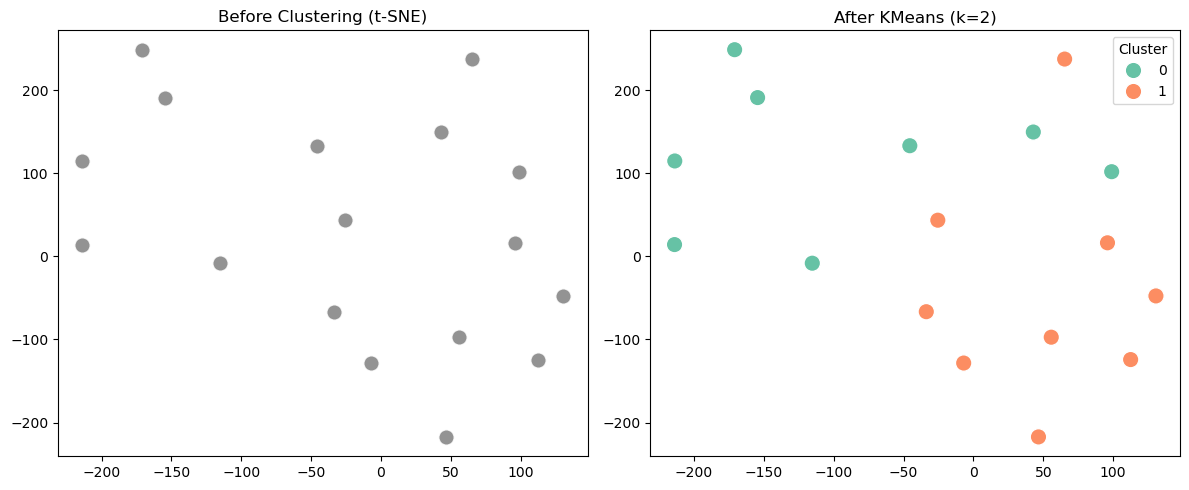

Saved clustered nodule-level file -> C:\Users\91888\Desktop\MI\Nodule_Level_Clusters.xlsx

Final grouped (first rows):


,patient_id,nodule_id,area,perimeter,equiv_diameter,solidity,eccentricity,compactness,margin_sharpness,mean_intensity,std_intensity,max_intensity,glcm_contrast,glcm_homogeneity,glcm_energy,glcm_entropy,Cluster
0,LIDC-IDRI-0001,nodule-0,719.375000,108.782116,30.036498,0.907637,0.490834,0.755237,20.070943,90.372093,40.426675,142.375000,169.703709,0.630509,0.458637,6.367045,0
1,LIDC-IDRI-0002,nodule-0,394.720000,75.719276,21.530056,0.944317,0.788520,0.805259,5.248932,1.595503,7.726856,53.920000,86.200495,0.677662,0.486069,5.816141,0
2,LIDC-IDRI-0003,nodule-0,305.375000,66.329320,17.995772,0.916453,0.537516,0.851049,0.000000,0.000000,0.000000,0.000000,208.532903,0.784590,0.717977,3.847883,0
3,LIDC-IDRI-0003,nodule-1,390.142857,76.382313,21.906911,0.913382,0.624900,0.823588,31.735917,93.926897,45.410253,146.428571,211.014201,0.735023,0.644895,4.729976,0
4,LIDC-IDRI-0003,nodule-2,82.500000,33.363961,10.223967,0.970837,0.770750,0.936982,58.839976,89.535811,60.070563,151.500000,107.111774,0.721568,0.508876,5.270445,0
5,LIDC-IDRI-0003,nodule-3,125.200000,38.659293,12.390277,0.973349,0.547061,1.020923,24.932469,49.652978,27.435351,74.000000,67.056631,0.693465,0.394518,6.056748,1
6,LIDC-IDRI-0005,nodule-0,37.500000,20.121320,6.906039,1.000000,0.458944,1.162787,0.000000,0.000000,0.000000,0.000000,183.622416,0.758561,0.554489,4.778058,1
7,LIDC-IDRI-0005,nodule-1,69.000000,29.071068,9.373021,0.971831,0.688094,1.025975,0.000000,0.000000,0.000000,0.000000,80.448081,0.617532,0.458185,6.332376,1
8,LIDC-IDRI-0006,nodule-0,32.000000,18.414214,6.379956,1.000000,0.524281,1.184379,0.000000,0.000000,0.000000,0.000000,82.635519,0.651431,0.460704,6.282880,1
9,LIDC-IDRI-0006,nodule-1,39.000000,20.828427,7.046726,0.975000,0.615920,1.129696,0.000000,0.000000,0.000000,0.000000,114.494156,0.809495,0.695871,3.642453,1


In [14]:
# ==========================================================
# Nodule-level aggregation + KMeans clustering + t-SNE plot
# Robust: groups slice rows into nodule rows, auto-selects k (silhouette),
# uses t-SNE for before/after plots with PCA fallback for speed.
# ==========================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

# ------------- user path (change if needed) ----------------
file_path = r"C:\Users\91888\Desktop\MI\Feature_Extraction_Output.xlsx"

# 1) Load file
df = pd.read_excel(file_path)
print("Loaded file:", file_path)
print("Original slice-level shape:", df.shape)
print("Columns:", df.columns.tolist())

# 2) Detect id columns (robust detection)
orig_cols = df.columns.tolist()
cols_low = [c.lower() for c in orig_cols]

def find_col(cands):
    for c in cands:
        if c in cols_low:
            return orig_cols[cols_low.index(c)]
    return None

patient_candidates = ['patient_id','patientid','patient','subject_id','subjectid','case_id','caseid']
nodule_candidates = ['nodule_id','noduleid','nodule','roi_id','roid','roi','region_id']
slice_candidates = ['slice','slice_number','slice_no','slice_index']

patient_col = find_col(patient_candidates)
nodule_col = find_col(nodule_candidates)
slice_col = find_col(slice_candidates)

print("Detected identifiers -> patient:", patient_col, "nodule:", nodule_col, "slice:", slice_col)

# 3) If any identifier missing, create safe fallbacks
if patient_col is None:
    df['_patient_tmp'] = 'patient_all'
    patient_col = '_patient_tmp'
if nodule_col is None:
    # If no explicit nodule_id, create a synthetic id per patient (last resort)
    df['_nodule_tmp'] = df[patient_col].astype(str) + "_nodule_1"
    nodule_col = '_nodule_tmp'
    print("No explicit nodule id found. Created synthetic nodule id:", nodule_col)

# 4) Select numeric feature columns to aggregate (exclude ids + slice)
exclude = {patient_col, nodule_col}
if slice_col is not None:
    exclude.add(slice_col)
feature_cols = [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]

# If no numeric features detected, coerce non-id columns to numeric where possible
if len(feature_cols) == 0:
    for c in df.columns:
        if c not in exclude:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    feature_cols = [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]

print("Numeric features to aggregate ({}):".format(len(feature_cols)))
print(feature_cols)

# 5) Group by patient + nodule and average slice-level features -> one nodule row
grouped = df.groupby([patient_col, nodule_col])[feature_cols].mean().reset_index()
print("Nodule-level grouped shape:", grouped.shape)

# Save grouped file for inspection
out_nodule = os.path.join(os.path.dirname(file_path), "Nodule_Level_Features.xlsx")
grouped.to_excel(out_nodule, index=False)
print("Saved nodule-level file ->", out_nodule)

# 6) Prepare data for clustering
X = grouped[feature_cols].fillna(0).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_samples = X_scaled.shape[0]
if n_samples < 2:
    raise ValueError("Not enough grouped nodules (%d) to cluster." % n_samples)

# 7) Choose k using silhouette (try 2..min(6,n_samples-1)), fallback to k=2 or 3
max_k = min(6, max(2, n_samples-1))
sil_scores = {}
for k in range(2, max_k+1):
    try:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labs = km.fit_predict(X_scaled)
        sil_scores[k] = silhouette_score(X_scaled, labs)
    except Exception:
        sil_scores[k] = np.nan

valid_scores = {k:v for k,v in sil_scores.items() if not np.isnan(v)}
if valid_scores:
    best_k = max(valid_scores, key=valid_scores.get)
else:
    best_k = min(3, n_samples)

print("Silhouette scores:", sil_scores)
print("Chosen k:", best_k)

# 8) Final KMeans
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
grouped['Cluster'] = kmeans.fit_predict(X_scaled)
print("Cluster counts:\n", grouped['Cluster'].value_counts())

# 9) t-SNE for visualization (safe parameters). If t-SNE fails or is slow, fallback to PCA
def plot_tsne_and_clusters(X_scaled, groups, out_title_suffix=""):
    n = X_scaled.shape[0]
    # choose a safe perplexity
    perp = int(min(30, max(5, max(5, n//3))))
    try:
        tsne = TSNE(n_components=2, perplexity=perp, learning_rate=200, random_state=42, init='pca', n_iter=1000)
        X_tsne = tsne.fit_transform(X_scaled)
        use_tsne = True
    except Exception as e:
        print("t-SNE failed or too slow, falling back to PCA. Error:", str(e))
        pca = PCA(n_components=2)
        X_tsne = pca.fit_transform(X_scaled)
        use_tsne = False

    plt.figure(figsize=(12,5))
    # BEFORE (gray)
    plt.subplot(1,2,1)
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], color='gray', s=120, alpha=0.85)
    t1 = "Before Clustering (t-SNE)" if use_tsne else "Before Clustering (PCA fallback)"
    plt.title(t1 + out_title_suffix)
    # AFTER (colored by cluster)
    plt.subplot(1,2,2)
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=grouped['Cluster'].astype(str), palette='Set2', s=140)
    t2 = f"After KMeans (k={best_k})"
    plt.title(t2 + out_title_suffix)
    plt.legend(title='Cluster', loc='best')
    plt.tight_layout()
    plt.show()

plot_tsne_and_clusters(X_scaled, grouped)

# 10) Save clustered grouped file
out_cluster = os.path.join(os.path.dirname(file_path), "Nodule_Level_Clusters.xlsx")
grouped.to_excel(out_cluster, index=False)
print("Saved clustered nodule-level file ->", out_cluster)
print("\nFinal grouped (first rows):")
display(grouped.head(30))


In [12]:
import pandas as pd import numpy as np from sklearn.preprocessing import StandardScaler from sklearn.cluster import KMeans from sklearn.manifold import TSNE import matplotlib.pyplot as plt import seaborn as sns # ================================ # 1️⃣ Load the Excel file (NEW PATH) # ================================ file_path = r"C:\Users\91888\Desktop\MI\Feature_Extraction_Output1.xlsx" df = pd.read_excel(file_path) print("✅ File loaded successfully. Shape:", df.shape) print("Columns:", df.columns.tolist()) # ===================================================== # 2️⃣ Group by Subject (patient_id) + Nodule (nodule_id) # → Average all feature values per nodule # ===================================================== group_cols = ['patient_id', 'nodule_id'] # Select only numeric feature columns feature_cols = df.select_dtypes(include=[np.number]).columns # Average numeric features for each (patient_id, nodule_id) nodule_level = df.groupby(group_cols)[feature_cols].mean().reset_index() print("✅ Averaged nodule-level data shape:", nodule_level.shape) # ========================================== # 3️⃣ Feature scaling for clustering # ========================================== X = nodule_level.drop(columns=group_cols, errors='ignore') X_scaled = StandardScaler().fit_transform(X) # ========================================== # 4️⃣ t-SNE visualization (before clustering) # ========================================== tsne = TSNE(n_components=2, random_state=42, perplexity=5) X_tsne = tsne.fit_transform(X_scaled) # ========================================== # 5️⃣ Apply K-Means Clustering (k=2 or 3) # ========================================== kmeans = KMeans(n_clusters=2, random_state=42, n_init=10) clusters = kmeans.fit_predict(X_scaled) nodule_level['Cluster'] = clusters # ========================================== # 6️⃣ Visualize before vs after clustering # ========================================== fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # Before clustering axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c='gray', s=60) axes[0].set_title("Before Clustering (t-SNE)") axes[0].set_xlabel("t-SNE 1") axes[0].set_ylabel("t-SNE 2") # After clustering sns.scatterplot( x=X_tsne[:, 0], y=X_tsne[:, 1], hue=nodule_level['Cluster'], palette='Set2', s=70, ax=axes[1] ) axes[1].set_title("After K-Means Clustering (k=2)") axes[1].set_xlabel("t-SNE 1") axes[1].set_ylabel("t-SNE 2") axes[1].legend(title="Cluster") plt.tight_layout() plt.show() # ========================================== # 7️⃣ Save the nodule-level clustered data # ========================================== output_path = r"C:\Users\91888\Desktop\MI\Nodule_Level_Clusters_50Subjects.xlsx" nodule_level.to_excel(output_path, index=False) print(f"✅ Saved clustered nodule-level file → {output_path}")

SyntaxError: invalid syntax (3247801377.py, line 1)

Using the following numeric features:
['area', 'perimeter', 'equiv_diameter', 'solidity', 'eccentricity', 'compactness', 'margin_sharpness', 'mean_intensity', 'std_intensity', 'min_intensity', 'max_intensity', 'glcm_contrast', 'glcm_homogeneity', 'glcm_energy', 'glcm_entropy']

========= CLUSTERING METRICS =========
Silhouette Score:          0.3210
Davies–Bouldin Score:      1.1514
Calinski–Harabasz Score:   56.1135



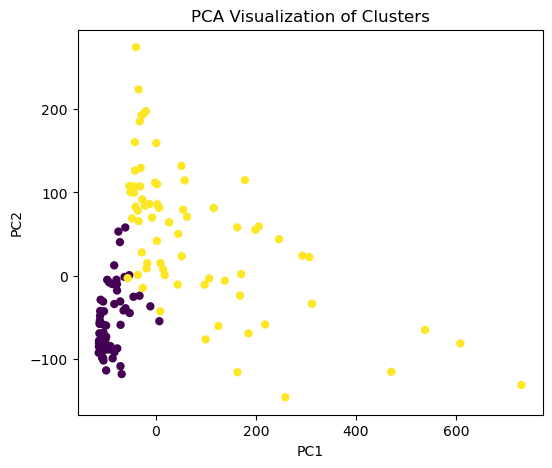

In [4]:
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# -------------------------
# 1. Load Excel
# -------------------------
path = r"C:\Users\91888\Desktop\MI\Nodule_Level_Clusters_50Subjects.xlsx"
df = pd.read_excel(path)

# -------------------------
# 2. Your cluster column is named 'Cluster'
# -------------------------
cluster_col = 'Cluster'
labels = df[cluster_col].values

# -------------------------
# 3. Remove non-numeric columns: patient_id, nodule_id, Cluster
# -------------------------
df_numeric = df.drop(columns=['patient_id', 'nodule_id', cluster_col])

# Confirm what numeric columns were selected
print("Using the following numeric features:")
print(df_numeric.columns.tolist())

X = df_numeric.values

# -------------------------
# 4. Compute Metrics
# -------------------------
sil = silhouette_score(X, labels)
db = davies_bouldin_score(X, labels)
ch = calinski_harabasz_score(X, labels)

print("\n========= CLUSTERING METRICS =========")
print(f"Silhouette Score:          {sil:.4f}")
print(f"Davies–Bouldin Score:      {db:.4f}")
print(f"Calinski–Harabasz Score:   {ch:.4f}")
print("======================================\n")

# -------------------------
# 5. PCA Visualization
# -------------------------
def visualize_clusters(X, labels):
    pca = PCA(n_components=2)
    X2 = pca.fit_transform(X)

    plt.figure(figsize=(6,5))
    plt.scatter(X2[:, 0], X2[:, 1], c=labels, s=25)
    plt.title("PCA Visualization of Clusters")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

visualize_clusters(X, labels)
